<h1>Natural Language Processing Assignment</h1>
<h2>Part A: Sentiment Analysis</h2>

<h3>Import Required Packages</h3>

In [4]:
import os
import re
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# my classes
from preprocessor import MyPreprocessor
from feature_generator import NormTech
from feature_generator import MyFeatureGenerator
from naive_bayes import MyNaiveBayesClassifier
from helpers import Helpers
helpers = Helpers()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leechilvers/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leechilvers/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leechilvers/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h3>Read in the Review Data</h3>

In [5]:
# Get the positive and negative reviews
def get_reviews_in(path):
    review_file_pattern = re.compile('\d+_\d+.txt')
    files = os.listdir(path)
    # get the review file names
    review_files = [file for file in files if review_file_pattern.match(file)] 
    # get the content of each review file
    reviews = []
    for review_file in review_files:
        review_file_path = os.path.join(path, review_file)
        with open(review_file_path, 'r') as content:
            reviews.append(content.read())

    return reviews

# x data
pos_reviews = get_reviews_in('film_reviews/pos')
neg_reviews = get_reviews_in('film_reviews/neg')
reviews = pos_reviews + neg_reviews

# y data
pos_labels = [0] * len(pos_reviews)
neg_labels = [1] * len(neg_reviews)
labels = pos_labels + neg_labels

<h3>Split the Reviews into Train, Dev and Test Sets</h3>

In [6]:
# split the data into train/dev/test splits
# 80% train and 20% test
x_train, x_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=42)
# split test into 50% dev and 50% test
x_dev, x_test, y_dev, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

<h3>Obtaining Feature Sets</h3>

<h4> n-grams </h4>
In order to decide what value of n should be used for the feature's n-grams, use MyPreprocessor to preprocess the review data with: 

- lemmatisation 
- lowercase
- stopwords removed
- punctuation removed

Then use standard frequency normalisation to generate features for MyNaiveBayesClassifier model. Observe the performance accuracy to make a decision for n.

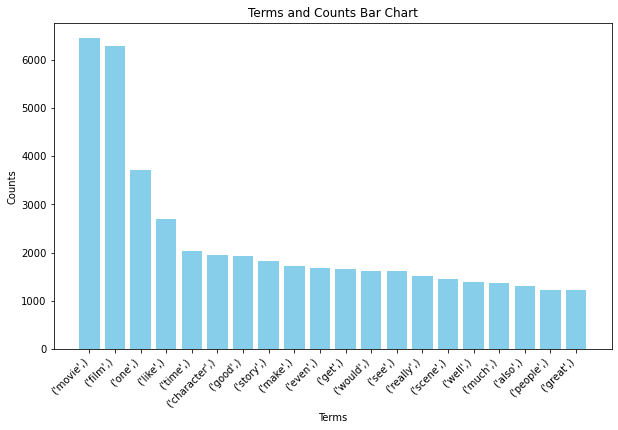

Features: 30341


In [5]:
# preprocess data using the methods specified

# unigrams
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=1)

# generate features with frequency normalisation
feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_unigrams = feature_generator.generate_features(train_revs, NormTech.FREQ_NORM)

# present graph of count of most common features
helpers.plot_graph(feature_generator, 20)

# do same with dev set to evaluate
dev_set_unigrams = feature_generator.generate_features(dev_revs, NormTech.FREQ_NORM)

print("Features: " + str(len(feature_generator.vocab)))

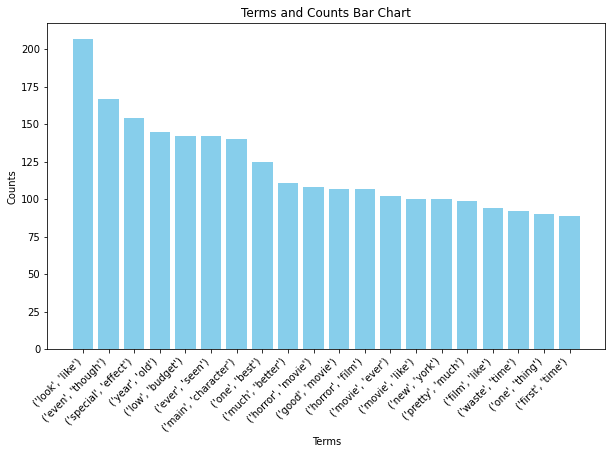

Features: 339061


In [8]:
# bigrams
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=2)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=2)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_bigrams = feature_generator.generate_features(train_revs, NormTech.FREQ_NORM)

helpers.plot_graph(feature_generator, 20)

dev_set_bigrams = feature_generator.generate_features(dev_revs, NormTech.FREQ_NORM)

print("Features: " + str(len(feature_generator.vocab)))

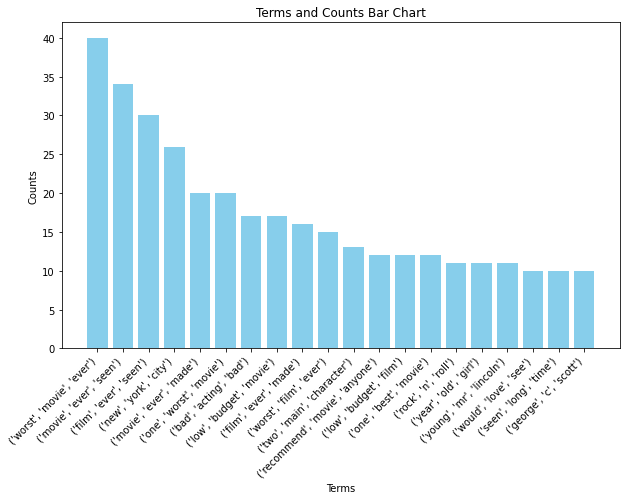

Features: 438312


In [9]:
# trigrams
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=3)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=3)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_trigrams = feature_generator.generate_features(train_revs, NormTech.FREQ_NORM)

helpers.plot_graph(feature_generator, 20)

dev_set_trigrams = feature_generator.generate_features(dev_revs, NormTech.FREQ_NORM)

print("Features: " + str(len(feature_generator.vocab)))

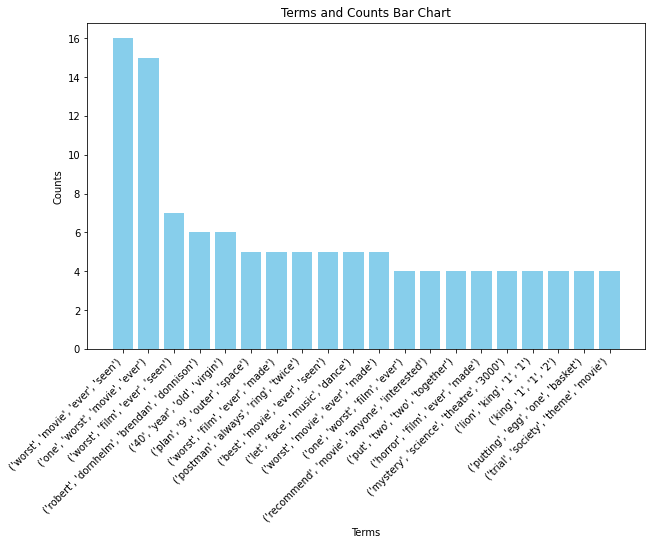

Features: 442258


In [10]:
# 4-gram
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=4)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=4)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_4grams = feature_generator.generate_features(train_revs, NormTech.FREQ_NORM)

helpers.plot_graph(feature_generator, 20)

dev_set_4grams = feature_generator.generate_features(dev_revs, NormTech.FREQ_NORM)

print("Features: " + str(len(feature_generator.vocab)))

Using MyNaiveBayesClassifier, decide what value for n gives the best accuracy. This is the value of n to take forward.

In [11]:
train_sets = [train_set_unigrams, train_set_bigrams, train_set_trigrams, train_set_4grams]
dev_sets = [dev_set_unigrams, dev_set_bigrams, dev_set_trigrams, dev_set_4grams]
accuracies_n_grams = []

my_clf = MyNaiveBayesClassifier()

for i, train_set in enumerate(train_sets):
    my_clf.fit(train_set, y_train)
    predictions = my_clf.predict(dev_sets[i])
    accuracies_n_grams.append(accuracy_score(y_dev, predictions))

%store accuracies_n_grams

Stored 'accuracies_n_grams' (list)
[0.77, 0.7425, 0.595, 0.5075]


In [22]:
%store -r accuracies_n_grams

# present accuracies in data frame
feature_set_names = ['Unigrams', 'Bigrams', 'Trigrams', '4-grams']
data_frame = pd.DataFrame(columns=['Feature Set', 'Accuracy'])
for i, feature_set_name in enumerate(feature_set_names):
    data_frame = data_frame.append({'Feature Set': feature_set_name, 'Accuracy': accuracies_n_grams[i]}, ignore_index=True)

data_frame

,Feature Set,Accuracy
0,Unigrams,0.7700
1,Bigrams,0.7425
2,Trigrams,0.5950
3,4-grams,0.5075


Despite catching more context in a feature, the trend shows that the larger the n-gram the worse the model performs in making predictoins. 

<h4>Combinations of Preprocessing Techniques</h4>
Having taken unigrams moving forward, create five feature sets using different combinations of preprocessing techniques and normalisation method.

These feature sets are:
1. stopwords removed, punctuation removed, lowercase, lemmatisation, TF-IDF
2. stopwords removed, punctuation NOT removed, NOT lowercase, lemmatisation, TF-IDF  
3. stopwords removed, punctuation removed, lowercase, lemmatisation, PPMI
4. stopwords removed, punctuation NOT removed, NOT lowercase, lemmatisation, PPMI
5. stopwords removed, punctuation removed, lowercase, stemming, TF-IDF

In [24]:
# Feature Set 1: stopwords removed, punctuation removed, lowercase, lemmatisation, TF-IDF
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_1 = feature_generator.generate_features(train_revs, NormTech.TF_IDF)
dev_set_1 = feature_generator.generate_features(dev_revs, NormTech.TF_IDF)

%store train_set_1
%store dev_set_1

Stored 'train_set_1' (ndarray)
Stored 'dev_set_1' (ndarray)


In [25]:
# Feature Set 2: stopwords removed, punctuation NOT removed, NOT lowercase, lemmatisation, TF-IDF
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=False, is_lowercase=False, is_lemmatisation=True)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=False, is_lowercase=False, is_lemmatisation=True)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_2 = feature_generator.generate_features(train_revs, NormTech.TF_IDF)
dev_set_2 = feature_generator.generate_features(dev_revs, NormTech.TF_IDF)

%store train_set_2
%store dev_set_2

Stored 'train_set_2' (ndarray)
Stored 'dev_set_2' (ndarray)


In [26]:
# Feature Set 3: stopwords removed, punctuation removed, lowercase, lemmatisation, PPMI
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_3 = feature_generator.generate_features(train_revs, NormTech.PPMI)
dev_set_3 = feature_generator.generate_features(dev_revs, NormTech.PPMI)

%store train_set_3
%store dev_set_3

/Users/leechilvers/Documents/Documents/#UoB/CompSci/NLP/SentimentAnalysis.nosync/feature_generator.py:112: RuntimeWarning: divide by zero encountered in log2
  matrix[matrix < 0] = 0


Stored 'train_set_3' (ndarray)
Stored 'dev_set_3' (ndarray)


In [27]:
# Feature Set 4: stopwords removed, punctuation NOT removed, NOT lowercase, lemmatisation, PPMI
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=False, is_lowercase=False, is_lemmatisation=True)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=False, is_lowercase=False, is_lemmatisation=True)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_4 = feature_generator.generate_features(train_revs, NormTech.PPMI)
dev_set_4 = feature_generator.generate_features(dev_revs, NormTech.PPMI)

%store train_set_4
%store dev_set_4

Stored 'train_set_4' (ndarray)
Stored 'dev_set_4' (ndarray)


In [28]:
# Feature Set 5: stopwords removed, punctuation removed, lowercase, stemming, TF-IDF
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=False)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=False)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_5 = feature_generator.generate_features(train_revs, NormTech.TF_IDF)
dev_set_5 = feature_generator.generate_features(dev_revs, NormTech.TF_IDF)

%store train_set_5
%store dev_set_5

Stored 'train_set_5' (ndarray)
Stored 'dev_set_5' (ndarray)


Evaluate with MyNaiveBayesClassifier and MultinomialNB

In [30]:
%store -r train_set_1 
%store -r train_set_2 
%store -r train_set_3 
%store -r train_set_4 
%store -r train_set_5
%store -r dev_set_1 
%store -r dev_set_2 
%store -r dev_set_3 
%store -r dev_set_4 
%store -r dev_set_5

train_sets = [train_set_1, train_set_2, train_set_3, train_set_4, train_set_5]
dev_sets = [dev_set_1, dev_set_2, dev_set_3, dev_set_4, dev_set_5]

set_names = ['train_set_1', 'train_set_2', 'train_set_3', 'train_set_4', 'train_set_5']
data_frame = pd.DataFrame(columns=['Feature Set', 'myclf Accuracy', 'clf Accuracy'])

for i, train_set in enumerate(train_sets):

    my_clf = MyNaiveBayesClassifier()
    my_clf.fit(train_set, y_train)
    my_clf_preds = my_clf.predict(dev_sets[i])
    my_clf_accuracy = accuracy_score(my_clf_preds, y_dev)

    clf = MultinomialNB()
    clf.fit(train_set, y_train)
    clf_preds = clf.predict(dev_sets[i])
    clf_accuracy = accuracy_score(clf_preds, y_dev)

    data_frame = data_frame.append({'Feature Set': set_names[i], 'myclf Accuracy': my_clf_accuracy, 'clf Accuracy': clf_accuracy}, ignore_index=True)

data_frame

,Feature Set,myclf Accuracy,clf Accuracy
0,train_set_1,0.7875,0.7300
1,train_set_2,0.7775,0.6450
2,train_set_3,0.7625,0.7500
3,train_set_4,0.7775,0.7625
4,train_set_5,0.7850,0.7475


Complete a 'sanity check' to make sure that a 4-gram would still perform worse after TF-IDF normalisation

In [31]:
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=4, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=4, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_6 = feature_generator.generate_features(train_revs, NormTech.TF_IDF)
dev_set_6 = feature_generator.generate_features(dev_revs, NormTech.TF_IDF)

clf = MultinomialNB()
clf.fit(train_set_6, y_train)
predictions = clf.predict(dev_set_6)
accuracy_score(predictions, y_dev)

0.4775

It consistently performs worse - continue using unigrams moving forward

Feature set 1 performed the best on the development set so therefore take this and demonstrate performance with the test set.

In [32]:
# Feature Set 1: stopwords removed, punctuation removed, lowercase, lemmatisation, TF-IDF
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)
test_revs = preprocessor.preprocess(x_test, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_1_B = feature_generator.generate_features(train_revs, NormTech.TF_IDF)
test_set_1 = feature_generator.generate_features(test_revs, NormTech.TF_IDF)

%store train_set_1_B
%store test_set_1

Stored 'train_set_1_B' (ndarray)
Stored 'test_set_1' (ndarray)


In [34]:
data_frame = pd.DataFrame(columns=['Feature Set', 'myclf Accuracy', 'clf Accuracy'])

my_clf = MyNaiveBayesClassifier()
my_clf.fit(train_set_1_B, y_train)
my_clf_preds = my_clf.predict(test_set_1)
my_clf_accuracy = accuracy_score(my_clf_preds, y_test)

clf = MultinomialNB()
clf.fit(train_set_1_B, y_train)
clf_preds = clf.predict(test_set_1)
clf_accuracy = accuracy_score(clf_preds, y_test)

data_frame = data_frame.append({'Feature Set': 'train_set_1', 'myclf Accuracy': my_clf_accuracy, 'clf Accuracy': clf_accuracy}, ignore_index=True)

data_frame

,Feature Set,myclf Accuracy,clf Accuracy
0,train_set_1,0.8125,0.755


<h3>SGD Based Classification and SVMs</h3>
Use one-hot embeddings for these features. Therefore it only makes sense to bring forward and use feature sets 1, 2 and 5.

In [38]:
# Feature Set 1: stopwords removed, punctuation removed, lowercase, lemmatisation, one hot embeddings
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=True)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_1_ONE_HOT = feature_generator.generate_features(train_revs, NormTech.ONE_HOT)
dev_set_1_ONE_HOT = feature_generator.generate_features(dev_revs, NormTech.ONE_HOT)

In [39]:
# Feature Set 2: stopwords removed, punctuation NOT removed, NOT lowercase, lemmatisation, one hot embeddings
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=False, is_lowercase=False, is_lemmatisation=True)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=False, is_lowercase=False, is_lemmatisation=True)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_2_ONE_HOT = feature_generator.generate_features(train_revs, NormTech.ONE_HOT)
dev_set_2_ONE_HOT = feature_generator.generate_features(dev_revs, NormTech.ONE_HOT)

In [40]:
# Feature Set 5: stopwords removed, punctuation removed, lowercase, stemming, one hot embeddings
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=False)
dev_revs = preprocessor.preprocess(x_dev, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=False)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_5_ONE_HOT = feature_generator.generate_features(train_revs, NormTech.ONE_HOT)
dev_set_5_ONE_HOT = feature_generator.generate_features(dev_revs, NormTech.ONE_HOT)

Perform an immediate evaluation on the development set with SGD and SVC classifiers

In [4]:
%store -r train_set_1_ONE_HOT 
%store -r train_set_2_ONE_HOT 
%store -r train_set_5_ONE_HOT
%store -r dev_set_1_ONE_HOT
%store -r dev_set_2_ONE_HOT
%store -r dev_set_5_ONE_HOT

train_sets = [train_set_1_ONE_HOT, train_set_2_ONE_HOT, train_set_5_ONE_HOT]
dev_sets = [dev_set_1_ONE_HOT, dev_set_2_ONE_HOT, dev_set_5_ONE_HOT]

set_names = ['train_set_1', 'train_set_2', 'train_set_5']
data_frame = pd.DataFrame(columns=['Feature Set', 'Logistic Regression', 'SVC'])

for i, train_set in enumerate(train_sets):

    log_reg = SGDClassifier(loss='log', random_state=42)
    log_reg.fit(train_set, y_train)
    log_reg_preds = log_reg.predict(dev_sets[i])
    log_reg_accuracy = accuracy_score(log_reg_preds, y_dev)

    svc = SVC(kernel='linear', C=1.0, random_state=42)    
    svc.fit(train_set, y_train)
    svc_preds = svc.predict(dev_sets[i])
    svc_accuracy = accuracy_score(svc_preds, y_dev)

    data_frame = data_frame.append({'Feature Set': set_names[i], 'Logistic Regression': log_reg_accuracy, 'SVC': svc_accuracy}, ignore_index=True)

data_frame

,Feature Set,Logistic Regression,SVC
0,train_set_1,0.8375,0.8550
1,train_set_2,0.8400,0.8375
2,train_set_5,0.8400,0.8550


Feature set 5 shows the best results for both. Take this one forward to tune hyperparameters for the models. 

(5 combinations for both Log Reg and SVC)

<h3> Logistic Regression Hyperparameters</h3> 

In [8]:
%store -r train_set_5_ONE_HOT
%store -r dev_set_5_ONE_HOT

hyperparams = [
    {'penalty': 'l2', 'alpha': 0.0001, 'learning_rate': 'optimal', 'max_iter': 1000}, # default
    {'penalty': 'l1', 'alpha': 0.0001, 'learning_rate': 'optimal', 'max_iter': 1000},
    {'penalty': 'l2', 'alpha': 0.0001, 'learning_rate': 'optimal', 'max_iter': 500},
    {'penalty': 'l2', 'alpha': 0.0001, 'learning_rate': 'constant', 'max_iter': 1000},
    {'penalty': 'l2', 'alpha': 0.01, 'learning_rate': 'optimal', 'max_iter': 1000},
]

data_frame = pd.DataFrame(columns=['penalty', 'alpha', 'learning_rate', 'max_iter', 'Accuracy'])

for hyperparam in hyperparams:
    log_reg = SGDClassifier(
        loss='log', 
        random_state=42, 
        penalty=hyperparam['penalty'],
        alpha=hyperparam['alpha'],
        learning_rate=hyperparam['learning_rate'],
        max_iter=hyperparam['max_iter'],
        et0=0.1
    )
    log_reg.fit(train_set_5_ONE_HOT, y_train)
    log_reg_preds = log_reg.predict(dev_set_5_ONE_HOT)
    log_reg_accuracy = accuracy_score(log_reg_preds, y_dev)

    hyperparam['Accuracy'] = log_reg_accuracy
    data_frame = data_frame.append(hyperparam, ignore_index=True)

data_frame

,penalty,alpha,learning_rate,max_iter,Accuracy
0,l2,0.0001,optimal,1000,0.8400
1,l1,0.0001,optimal,1000,0.8100
2,l2,0.0001,optimal,500,0.8400
3,l2,0.0001,constant,1000,0.8550
4,l2,0.0100,optimal,1000,0.8675


<h3>SVC Hyperparameters</h3>

In [12]:
%store -r train_set_5_ONE_HOT
%store -r dev_set_5_ONE_HOT

hyperparams = [
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'shrinking': True},
    {'kernel': 'linear', 'C': 1.0, 'gamma': 'scale', 'shrinking': True},
    {'kernel': 'sigmoid', 'C': 1.0, 'gamma': 'scale', 'shrinking': True},
    {'kernel': 'rbf', 'C': 2.0, 'gamma': 'scale', 'shrinking': True},
    {'kernel': 'rbf', 'C': 0.5, 'gamma': 'scale', 'shrinking': True},
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'auto', 'shrinking': True},
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'shrinking': False},
]

data_frame = pd.DataFrame(columns=['kernel', 'C', 'gamma', 'shrinking', 'Accuracy'])

for hyperparam in hyperparams:
    svc = SVC(
        kernel=hyperparam['kernel'], 
        C=hyperparam['C'], 
        gamma=hyperparam['gamma'],
        shrinking=hyperparam['shrinking'],
        random_state=42
    )    
    svc.fit(train_set_5_ONE_HOT, y_train)
    svc_preds = svc.predict(dev_set_5_ONE_HOT)
    svc_accuracy = accuracy_score(svc_preds, y_dev)

    hyperparam['Accuracy'] = svc_accuracy
    data_frame = data_frame.append(hyperparam, ignore_index=True)

data_frame

,kernel,C,gamma,shrinking,Accuracy
0,rbf,1.0,scale,True,0.8700
1,linear,1.0,scale,True,0.8550
2,sigmoid,1.0,scale,True,0.8625
3,rbf,2.0,scale,True,0.8675
4,rbf,0.5,scale,True,0.8325
5,rbf,1.0,auto,True,0.4775
6,rbf,1.0,scale,False,0.8700


Check performance on Test Split

In [13]:
# Feature Set 5: stopwords removed, punctuation removed, lowercase, stemming, one hot embeddings
preprocessor = MyPreprocessor()
train_revs = preprocessor.preprocess(x_train, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=False)
test_revs = preprocessor.preprocess(x_test, n_gram_len=1, is_stopwords_removed=True, is_punctuation_removed=True, is_lowercase=True, is_lemmatisation=False)

feature_generator = MyFeatureGenerator(preprocessor.vocab)
train_set_5_ONE_HOT_B = feature_generator.generate_features(train_revs, NormTech.ONE_HOT)
test_set_5_ONE_HOT = feature_generator.generate_features(test_revs, NormTech.ONE_HOT)

In [15]:
data_frame = pd.DataFrame(columns=['Feature Set', 'Logistic Regression', 'SVC'])

log_reg = SGDClassifier(
    loss='log', 
    random_state=42, 
    penalty='l2',
    alpha=0.01,
    learning_rate='optimal',
    max_iter=1000
)
log_reg.fit(train_set_5_ONE_HOT_B, y_train)
log_reg_preds = log_reg.predict(test_set_5_ONE_HOT)
log_reg_accuracy = accuracy_score(log_reg_preds, y_test)

svc = SVC(
    kernel='rbf', 
    C=1.0, 
    gamma='scale',
    shrinking=True,
    random_state=42
)    
svc.fit(train_set_5_ONE_HOT_B, y_train)
svc_preds = svc.predict(test_set_5_ONE_HOT)
svc_accuracy = accuracy_score(svc_preds, y_test)

data_frame = data_frame.append({'Feature Set': 'train_set_5', 'Logistic Regression': log_reg_accuracy, 'SVC': svc_accuracy}, ignore_index=True)

data_frame

,Feature Set,Logistic Regression,SVC
0,train_set_5,0.8675,0.875


<h3>BERT</h3>
Please reference assignment_BERT.ipynb

<h2>Final Comparison of Results</h2>